We load the preprocessed dataset and use the train_val_test_split function defined in the file with the same name. We also drop the columns month and city since we want to predict in general, not for a specific city.

In [1]:
import pandas as pd
import numpy as np

In [2]:
weather_data = pd.read_csv('datasets/processed_dataset.csv')
weather_data = weather_data.drop(columns=['MONTH', 'CITY'])

In [3]:
from train_val_test_split import train_val_test_split
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(weather_data)

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

We first fit a baseline for our model, with parameters set to their default values. We do this for three Kernel functions, and continue with the Kernel function which performs best. We will then fine-tune the hyper-parameters for this Kernel function.

In [11]:
# First we try RBF kernel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, accuracy_score

baseline_svm_pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
    ))
])

baseline_svm_pipe_rbf.fit(X_train, y_train.ravel())
y_pred_base_rbf = baseline_svm_pipe_rbf.predict(X_val)

baseline_f2_rbf = fbeta_score(y_val, y_pred_base_rbf, beta=2)
print(f"Baseline f2 score RBF: {baseline_f2_rbf}")

accuracy_rbf = accuracy_score(y_val, y_pred_base_rbf)
print(f"Baseline accuracy RBF: {accuracy_rbf}")

Baseline f2 score RBF: 0.8067718098599316
Baseline accuracy RBF: 0.7978082191780822


In [12]:
# Then a polynomial

baseline_svm_poly_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="poly",
    ))
])

baseline_svm_poly_pipe.fit(X_train, y_train.ravel())
y_pred_base_poly = baseline_svm_poly_pipe.predict(X_val)

baseline_f2_poly = fbeta_score(y_val, y_pred_base_poly, beta=2)
print(f"Baseline f2 score polynomial: {baseline_f2_poly}")

accuracy_poly = accuracy_score(y_val, y_pred_base_poly)
print(f"Baseline accuracy polynomial: {accuracy_poly}")

Baseline f2 score polynomial: 0.8505182177583075
Baseline accuracy polynomial: 0.7884931506849315


In [13]:
# And lastly, sigmoid

baseline_svm_sigmoid_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="sigmoid",
    ))
])

baseline_svm_sigmoid_pipe.fit(X_train, y_train.ravel())
y_pred_base_sigmoid = baseline_svm_sigmoid_pipe.predict(X_val)

baseline_f2_sigmoid = fbeta_score(y_val, y_pred_base_sigmoid, beta=2)
print(f"Baseline f2 score: {baseline_f2_sigmoid}")

accuracy_sigmoid = accuracy_score(y_val, y_pred_base_sigmoid)
print(f"Baseline accuracy sigmoid: {accuracy_sigmoid}")

Baseline f2 score: 0.6976103953309107
Baseline accuracy sigmoid: 0.6865753424657535


We found that polynomial had the highest F2 score, but also a quite lower accuracy compared to F2. The accuracy and F2 for polynomial is quite similar, however since we value F2 a bit higher as stated in our report, polynomial looks like our best kernel function. The sigmoid function did not perform very well so we will not continue with that. However, since polynomial is quite computationally costly compared to RBF and also the lower accuracy, we will also fine-tune a model with RBF.

## RBF Kernel

First we do the RBF Kernel

In [14]:
C_values = [0.1, 1, 10]
gamma_values = ["scale", 0.01, 0.1, 1]

results = []

for C in C_values:
    for gamma in gamma_values:
        svm_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,

            ))
        ])

        svm_pipe.fit(X_train, y_train)

        y_val_pred = svm_pipe.predict(X_val)
        f2 = fbeta_score(y_val, y_val_pred, beta=2)

        results.append({
            "C": C,
            "gamma": gamma,
            "f2": f2
        })

In [15]:
best_param_rbf = max(results, key=lambda x: x["f2"])
best_param_rbf

{'C': 0.1, 'gamma': 0.01, 'f2': 0.8259779884493843}

We then train the model with the best hyperparameters on the trainval set and compare this to the test set for performance

In [38]:
X_trainval = pd.concat([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

best_model_pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=0.1,
        gamma=0.01
    ))
])

best_model_pipe_rbf.fit(X_train, y_train)
y_best_model_pred_rbf = best_model_pipe_rbf.predict(X_val)
f2_final_model_rbf = fbeta_score(y_val, y_best_model_pred_rbf, beta=2)
print(f"The f2 score for the final model is {f2_final_model_rbf}")
accuracy_final_rbf = accuracy_score(y_val, y_best_model_pred_rbf)
print(f"Accuracy final RBF: {accuracy_final_rbf}")

The f2 score for the final model is 0.8259779884493843
Accuracy final RBF: 0.7967123287671233


We also plot a ROC curve and compute the auc for the ROC curve for the baseline model and final model

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

baseline_scores_rbf = baseline_svm_pipe_rbf.decision_function(X_val)
final_scores_rbf = best_model_pipe_rbf.decision_function(X_val)

fpr_base_rbf, tpr_base_rbf, _ = roc_curve(y_val, baseline_scores_rbf)
fpr_final_rbf, tpr_final_rbf, _ = roc_curve(y_val, final_scores_rbf)

auc_base_rbf = roc_auc_score(y_val, baseline_scores_rbf)
auc_final_rbf = roc_auc_score(y_val, final_scores_rbf)

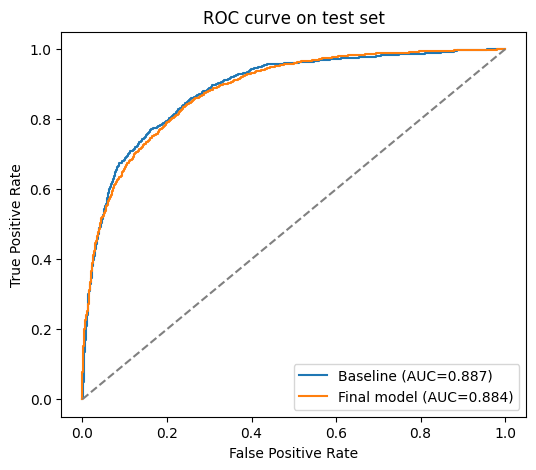

The area under curve for baseline: 0.8871160754691596
The area under curve for final model: 0.8843917912319008
The AUC of the baseline is 0.0027242842372587894 higher than our final model


In [43]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_base_rbf, tpr_base_rbf, label=f"Baseline (AUC={auc_base_rbf:.3f})")
plt.plot(fpr_final_rbf, tpr_final_rbf, label=f"Final model (AUC={auc_final_rbf:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

print(f"The area under curve for baseline: {auc_base_rbf}")
print(f"The area under curve for final model: {auc_final_rbf}")
print(f"The AUC of the baseline is {auc_base_rbf-auc_final_rbf} higher than our final model")

Checking difference between training and validation

In [44]:
y_train_pred_rbf = best_model_pipe_rbf.predict(X_train)
y_val_pred_rbf = best_model_pipe_rbf.predict(X_val)
f2_train_rbf = fbeta_score(y_train, y_train_pred_rbf, beta=2)
f2_val_rbf = fbeta_score(y_val, y_val_pred_rbf, beta=2)

In [45]:
print(f2_train_rbf - f2_val_rbf)

0.0004741503322012175


## Polynomial

For the polynomial, we will only fine-tune the C values and coef0 values, since our model already performed pretty well on the baseline with default of 3 degrees, and adding 3 more possible values for degrees would have us train 3x as many models, increasing the computational cost (when I tried this, the notebook did not manage to compute it inside a reasonable time, and running the grid_search for these three values already takes around 2min)

In [25]:
C_values = [0.1, 1, 10]
coef0_values = [0.1, 1, 10]

results = []

for C in C_values:
    for coef0 in coef0_values:
        svm_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(
                kernel="poly",
                C=C,
                coef0=coef0,

            ))
        ])

        svm_pipe.fit(X_train, y_train)

        y_val_pred = svm_pipe.predict(X_val)
        f2 = fbeta_score(y_val, y_val_pred, beta=2)

        results.append({
            "C": C,
            "coef0": coef0,
            "f2": f2
        })

In [26]:
best_param_poly = max(results, key=lambda x: x["f2"])
print(best_param_poly)

{'C': 0.1, 'coef0': 0.1, 'f2': 0.844761088493679}


In [46]:
best_model_pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="poly",
        C=0.1,
        coef0=0.1
    ))
])

best_model_pipe_poly.fit(X_train, y_train)
y_best_model_pred_poly = best_model_pipe_poly.predict(X_val)
f2_final_model_poly = fbeta_score(y_val, y_best_model_pred_poly, beta=2)
print(f"The f2 score for the final model is {f2_final_model_poly}")

accuracy_final_poly = accuracy_score(y_val, y_best_model_pred_poly)
print(f"Accuracy polynomial: {accuracy_final_poly}")

The f2 score for the final model is 0.844761088493679
Accuracy polynomial: 0.7871232876712329


In [31]:
y_train_pred_poly = best_model_pipe_poly.predict(X_train)
y_val_pred_poly = best_model_pipe_poly.predict(X_val)
f2_train_poly = fbeta_score(y_train, y_train_pred_poly, beta=2)
f2_val_poly = fbeta_score(y_val, y_val_pred_poly, beta=2)

In [32]:
print(f2_train_poly - f2_val_poly)

-0.0004760050761003498


In [47]:
baseline_scores_poly = baseline_svm_poly_pipe.decision_function(X_val)
final_scores_poly = best_model_pipe_poly.decision_function(X_val)

fpr_base_poly, tpr_base_poly, _ = roc_curve(y_val, baseline_scores_poly)
fpr_final_poly, tpr_final_poly, _ = roc_curve(y_val, final_scores_poly)

auc_base_poly = roc_auc_score(y_val, baseline_scores_poly)
auc_final_poly = roc_auc_score(y_val, final_scores_poly)

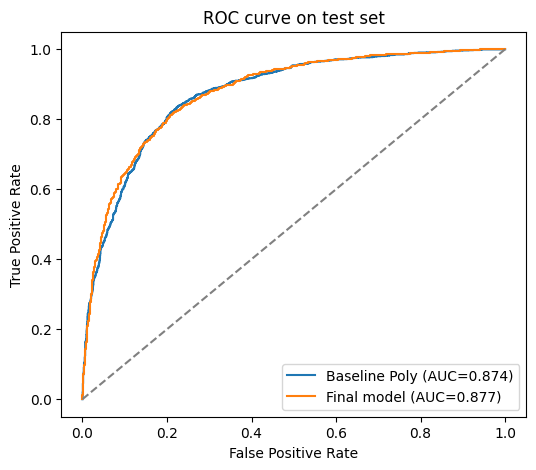

The area under curve for baseline: 0.8736880448305716
The area under curve for final model: 0.8771075140335773
The AUC of the baseline is -0.0034194692030057317 higher than our final model


In [48]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_base_poly, tpr_base_poly, label=f"Baseline Poly (AUC={auc_base_poly:.3f})")
plt.plot(fpr_final_poly, tpr_final_poly, label=f"Final model (AUC={auc_final_poly:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

print(f"The area under curve for baseline: {auc_base_poly}")
print(f"The area under curve for final model: {auc_final_poly}")
print(f"The AUC of the baseline is {auc_base_poly-auc_final_poly} higher than our final model")

## Confusion Matrices for both Kernel functions

Text(0.5, 1.0, 'Precipitation or not')

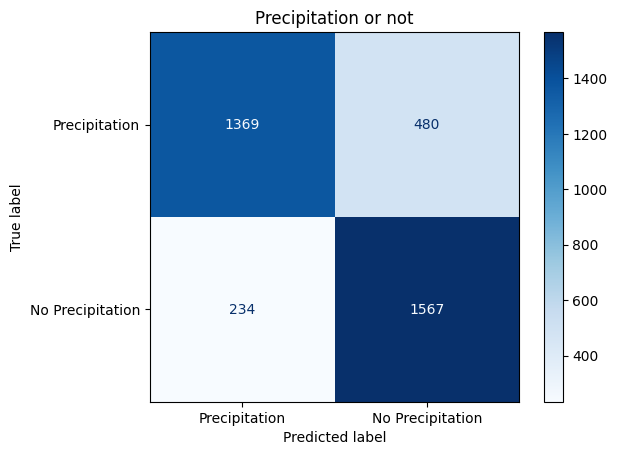

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_polynomial = confusion_matrix(y_val, y_val_pred_poly)
display_poly = ConfusionMatrixDisplay(cm_polynomial, display_labels=["Precipitation", "No Precipitation"])
display_poly.plot(cmap=plt.cm.Blues)
plt.title('Precipitation or not')                                

Text(0.5, 1.0, 'Precipitation or not')

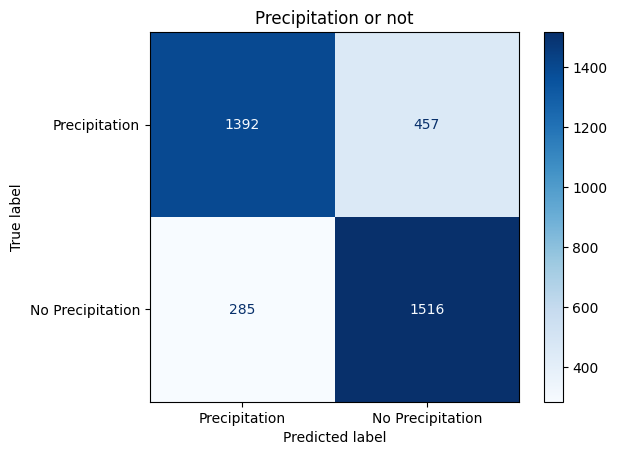

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_rbf = confusion_matrix(y_val, y_val_pred_rbf)
display_rbf = ConfusionMatrixDisplay(cm_rbf, display_labels=["Precipitation", "No Precipitation"])
display_rbf.plot(cmap=plt.cm.Blues)
plt.title('Precipitation or not')                                